In [1]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.reader as reader

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_file = '../input/fashion-mnist_train.csv'
test_file = '../input/fashion-mnist_test.csv'

In [3]:
feature_columns = [tf.feature_column.numeric_column('pixels', shape=[28,28])]
classifier = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=10,
    model_dir='./fashion-model'
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './fashion-model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022106C09588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [4]:
def generate_labelled_input_fn(csv_files, batch_size):
    def input_fn():
        file_queue = tf.train.string_input_producer(csv_files)
        textLine_reader = tf.TextLineReader(skip_header_lines=1)
        _, rows = textLine_reader.read_up_to(file_queue, num_records=100*batch_size)
        expanded_rows = tf.expand_dims(rows, axis=-1)
        
        shuffled_rows = tf.train.shuffle_batch(
            [expanded_rows],
            batch_size=batch_size,
            capacity=20*batch_size,
            min_after_dequeue=5*batch_size,
            enqueue_many=True
        )

        record_defaults = [[0] for _ in range(28*28+1)]

        columns = tf.decode_csv(shuffled_rows, record_defaults=record_defaults)

        labels = columns[0]

        pixels = tf.concat(columns[1:], axis=1)

        return {'pixels': pixels}, labels
    
    return input_fn

In [5]:
BATCH_SIZE = 40
TRAIN_STEPS = 2500

In [6]:
classifier.train(
    input_fn=generate_labelled_input_fn([train_file], BATCH_SIZE),
    steps=TRAIN_STEPS
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fashion-model\model.ckpt-37000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 37001 into ./fashion-model\model.ckpt.
INFO:tensorflow:loss = 461.52597, step = 37001
INFO:tensorflow:global_step/sec: 44.4599
INFO:tensorflow:loss = 387.54587, step = 37101 (2.238 sec)
INFO:tensorflow:global_step/sec: 70.5124
INFO:tensorflow:loss = 173.80042, step = 37201 (1.415 sec)
INFO:tensorflow:global_step/sec: 71.4485
INFO:tensorflow:loss = 1096.4036, step = 37301 (1.400 sec)
INFO:tensorflow:global_step/sec: 71.7706
INFO:tensorflow:loss = 484.35614, step = 37401 (1.395 sec)
INFO:tensorflow:global_step/sec: 71.8016
INFO:tensorflow:loss = 1139.1398, step = 37501 (1.390 sec)
INFO:tensorflow:global_step/sec: 56.484
INFO:tensorflow:loss = 

In [7]:
classifier.evaluate(
    input_fn=generate_labelled_input_fn([test_file], BATCH_SIZE),
    steps=100
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-06-06:36:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fashion-model\model.ckpt-39500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-03-06-06:36:14
INFO:tensorflow:Saving dict for global step 39500: accuracy = 0.8055, average_loss = 18.70167, global_step = 39500, loss = 748.0668


{'accuracy': 0.8055,
 'average_loss': 18.70167,
 'global_step': 39500,
 'loss': 748.0668}

In [8]:
CLASSES = {
    '0': 'T-shirt/top',
    '1': 'Trouser',
    '2': 'Pullover',
    '3': 'Dress',
    '4': 'Coat',
    '5': 'Sandal',
    '6': 'Shirt',
    '7': 'Sneaker',
    '8': 'Bag',
    '9': 'Ankle boot'
}

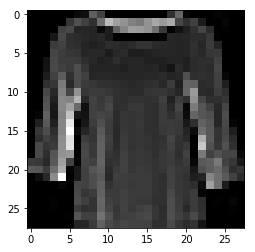

In [9]:
test_data = pd.read_csv(test_file)
sample_data = test_data.sample()

sample = list(sample_data.iloc[0])
label = sample[0]
pixels = sample[1:]

image_array = np.asarray(pixels, dtype=np.float32).reshape((28, 28))
plt.imshow(image_array, cmap='gray')

In [10]:
def generate_prediction_input_fn(image_arrays):
    def input_fn():
        queue = tf.train.input_producer(
            tf.constant(np.asarray(image_arrays)),
            num_epochs=1
        )
        
        image = queue.dequeue()
        return {'pixels': [image]}
    
    return input_fn

In [11]:
predictions = classifier.predict(
    generate_prediction_input_fn([image_array]),
    predict_keys=['probabilities', 'classes']
)

In [12]:
prediction = next(predictions)
# print('Prediction output: {}'.format(prediction))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fashion-model\model.ckpt-39500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [13]:
print(prediction)

{'probabilities': array([1.0000000e+00, 0.0000000e+00, 2.2853594e-14, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.2856651e-36, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), 'classes': array([b'0'], dtype=object)}


In [14]:
print('Actual label: {} - {}'.format(label, CLASSES[str(label)]))
predicted_class = prediction['classes'][0].decode('utf-8')
probability = prediction['probabilities'][int(predicted_class)]
print('Predicted class: {} - {} with probability {}'.format(
    predicted_class,
    CLASSES[predicted_class],
    probability
))

Actual label: 2 - Pullover
Predicted class: 0 - T-shirt/top with probability 1.0
